In [159]:
import cv2
from keras.models import load_model
from keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models
import keras
import os
from tensorflow.python.keras.preprocessing import image
from keras import backend as K
from keras.models import load_model
import numpy as np
from tensorflow.keras.applications.vgg16 import preprocess_input

model = models.load_model('../model/vgg16_mass_benign_or_malignant_best_Adam.h5')
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0   

In [160]:
def load_testing():
    images = np.load(os.path.join('../Data_final_massver', 'X_test.npy'))
    labels = np.load(os.path.join('../Data_final_massver', 'test_mass_labels2_num.npy'))
    FN = np.load(os.path.join('../Data_final_massver', 'test_mass_FN.npy'))
    return images, labels, FN

In [211]:
test_images, test_labels, test_FN= load_testing()
n_test_img = test_images.shape[0]

test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

#test_images = test_images.reshape((n_test_img, 256, 256, 1))

test_images = test_images.astype('uint16')/256
test_images = np.repeat(test_images, 3, axis=3)

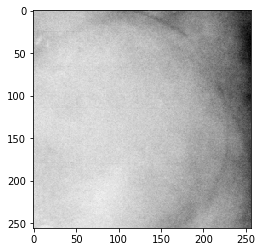

Label: [1. 0.]
FN: Mass-Training_P_01297_LEFT_CC.png


In [213]:
idx = 127

plt.imshow(test_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(test_labels[idx]))
print("FN: " + str(test_FN[idx]))


In [214]:
x = test_images[idx]
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [215]:
x.shape

(1, 256, 256, 3)

In [216]:
preds = model.predict(x)

In [217]:
preds

array([[0.85980153, 0.14019845]], dtype=float32)

In [218]:
np.argmax(preds[0])

0

idx = 99 FN: Mass-Training_P_00334_LEFT_MLO.png

In [239]:
img_path = 'full.png'
img = image.load_img(img_path, target_size = (256, 256))
x = image.img_to_array(img)
x = np.expand_dims(x, axis= 0)
x = preprocess_input(x) 

img=cv2.imread('full.png')
dst = cv2.resize(img, dsize=(256,256), interpolation=cv2.INTER_AREA)
dst=dst.reshape(1,256,256,3)

preds = model.predict(x)
print(preds)

[[0.07964293 0.92035705]]


In [240]:
np.argmax(preds[0])

1

In [252]:
mymodel_output = model.output[:, np.argmax(preds[0])]
last_conv_layer = model.get_layer('block5_conv3')
print(last_conv_layer)
grads = K.gradients(mymodel_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
    
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)

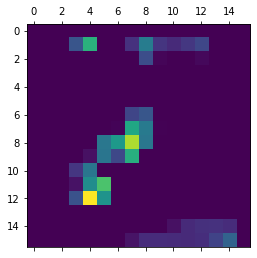

In [253]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

plt.matshow(heatmap)

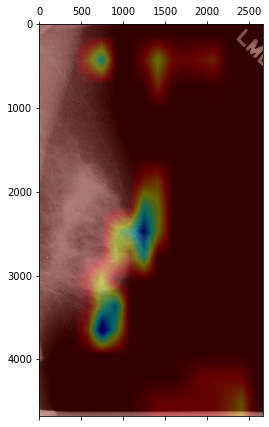

In [254]:
background=image.img_to_array(img)
heatmap1 = cv2.resize(heatmap, (background.shape[1], background.shape[0]))
heatmap2 = np.uint8(255 * heatmap1)                     
heatmap3 = cv2.applyColorMap(heatmap2, cv2.COLORMAP_JET)

superimposed_img =  np.uint8(heatmap3 * 0.4+ background*0.6)
plt.matshow(superimposed_img)
plt.show()